In [32]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import prettytable as pt
%run helpers_compare.ipynb
%run helpers_preproc.ipynb
%matplotlib widget

# Hyper Parameters

In [4]:
origDataDir = 'SHREC11/'
newDataDir = 'SHREC11_plus/' 
K = 252 
radiuss = [0.0002,0.002,0.01]
train_size = 450 * len(radiuss)
test_size = (600-450) * len(radiuss)

# 1. expand dataset and scramble

In [5]:
expand(origDataDir, newDataDir, radiuss) 
scramble(newDataDir, 10000,600 * len(radiuss))

# 2. read in the dataset

## 2.1 read in v (252 x 3),f (...x...) and cluster

In [6]:
ver_list = []
adj_list = []
Nadj_list = []
gMat_list = []
gLbl_list = []

for i in range(600 * len(radiuss)):
    v, f = get_nodes(newDataDir + 'T' + str(i) + '.obj')
    group_mat, group_labels = K_mean_cluster(v, K)
    
    adj = get_adj_from_f(f)            
    normed_adj = adj / np.reshape(np.sum(adj,axis = 0),[252,1])
    ver_list.append(v)
    adj_list.append(adj)
    Nadj_list.append(normed_adj)
    gMat_list.append(group_mat)
    gLbl_list.append(group_labels)
    
    
vers = np.array(ver_list)
adjs = np.array(adj_list)
Nadjs = np.array(Nadj_list)
gMats = np.array(gMat_list)
gLbls = np.array(gLbl_list)

/Users/richardwang/.conda/envs/TSM/lib/python3.10/site-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_10942/2399023897.py:12: RuntimeWarning: invalid value encountered in divide
  normed_adj = adj / np.reshape(np.sum(adj,axis = 0),[252,1])


## 2.2 Read in the labels

In [7]:
label_np = np.array(readLbl(600 * len(radiuss),newDataDir+'labels.txt'))
label_np_train = label_np[:train_size]
label_np_test = label_np[train_size:]

## 2.3 Split into training set and testing set

In [8]:
vers_train = torch.tensor(vers[:train_size]).float()
adjs_train = torch.tensor(adjs[:train_size]).float()
nadjs_train = torch.nan_to_num(torch.tensor(Nadjs[:train_size]).float(),0,0,0)
gMats_train = torch.tensor(gMats[:train_size]).float()
label_train = torch.tensor(label_np_train).float()

vers_test = torch.tensor(vers[train_size:]).float()
adjs_test = torch.tensor(adjs[train_size:]).float()
nadjs_test = torch.nan_to_num(torch.tensor(Nadjs[train_size:]).float(),0,0,0)
gMats_test = torch.tensor(gMats[train_size:]).float()
label_test = torch.tensor(label_np_test).float()

label_mat_train = torch.tensor(np.where(igl.all_pairs_distances(label_np_train,label_np_train,False) > 0.5,0,1)).float()
label_mat_test = torch.tensor(np.where(igl.all_pairs_distances(label_np_test,label_np_test,False) > 0.5,0,1)).float()

# 3. Training

## 3.1 Hyperparameters for training

In [9]:
contraGWs = [10,10,10,10]
contraMWs = [10,10,10,10]
atkGWs = [10,10,10,10]
atkMWs = [10,10,10,K * 3 + 1]

## 3.2 Initialize neural networks

In [10]:
%run NNs.ipynb
%run helpers_preproc.ipynb
# loadWeightDir = 'weights/3-29/'

In [11]:
load_model = False

In [12]:
contraG = GCN(3,contraGWs)
contraM = MLP(252* contraGWs[len(contraGWs)-1],contraMWs)
atkG = GCN(3,atkGWs)
atkM = MLP_atk(252* atkGWs[len(contraGWs)-1], 90, K, atkMWs)

if load_model:
    contraG.weights = torch.load(loadWeightDir + 'contraGw.pt')
    contraM.weights = torch.load(loadWeightDir + 'contraMw.pt')
    atkG.weights = torch.load(loadWeightDir + 'atkGw.pt')
    atkM.weights = torch.load(loadWeightDir + 'atkMw.pt')

## 3.4 Extract node-level features from clean data

In [13]:
feas_clean = extract_node_feature(vers_train,adjs_train)

In [14]:
%run L.ipynb

## 3.5 Train atkNN😈 with contraNN🤠

In [15]:
lr = 0.0001
torch.set_printoptions(precision=10)

Loss Defined to be: 

$\text{-diffTypeMean + sameTypeMean} + 0.02 \times \sqrt{\text{sameTypeStd}}$

In [24]:
#get clean features
feas_clean = extract_node_feature(vers_train,adjs_train) #grad on nothing
opt = optim.Adam(atkG.weights + atkM.weights + contraG.weights + contraM.weights, lr = lr)

for contraI in range(10000):
    trainLog = pt.PrettyTable()
    trainLog.field_names = [" ","Loss", "Same Mean", "Diff Mean", "Same STD"]
    
    
    opt.zero_grad()

    #get poisoned vertex locations
    poisonsByGroups = atkM.forward(atkG.forward(nadjs_train,feas_clean))
    transformation = translate_by_group(gMats_train,
                                        poisonsByGroups)
    poisonedVers = vers_train + transformation
        
        
    #extract poisoned features
    feas_poisoned = extract_node_feature(poisonedVers,adjs_train) #grad on 😈

    
    #get contraNN's performance on poisoned feature with grads on 😈    
    contraM.eval()
    contraG.eval()
    aPerfPoisoned, APP = loss(contraM.forward(contraG.forward(nadjs_train,feas_poisoned)),
                         label_mat_train) #grad on 😈
    
    #get contraNN's performance on clean feature and poisoned feature with grads on 🤠
    contraM.train()
    contraG.train()
    feas_poisoned_nograd = feas_poisoned.detach() #grad on nothing
    
    objFeasFromClean = contraM.forward(contraG.forward(nadjs_train,feas_clean))
    objFeasFromPoisoned = contraM.forward(contraG.forward(nadjs_train,feas_poisoned_nograd))
    
    diffInFeas = torch.sum((objFeasFromClean - objFeasFromPoisoned)**2)
    
    cPerfClean, CPC = loss(objFeasFromClean,
                      label_mat_train) #grad on 🤠
    
    cPerfPoisoned, CPP = loss(objFeasFromPoisoned,
                         label_mat_train) #grad on 🤠
    
    
    trainLog.add_row(['On Clean Data']+CPC)
    trainLog.add_row(['On Poisoned Data']+CPP)

    
    overallLoss = -aPerfPoisoned + cPerfClean + 1 * cPerfPoisoned#  + diffInFeas
    #overallLoss = -aPerfPoisoned
    overallLoss.backward()
    opt.step()
    
    print(trainLog)

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.02114 |  0.09356  |  0.14899  | 0.51708  |
| On Poisoned Data | -0.02057 |   0.0846  |  0.13315  | 0.46499  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.02138 |  0.09436  |  0.15073  |  0.5214  |
| On Poisoned Data | -0.02079 |  0.08541  |  0.13478  | 0.46953  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.02396 |  0.09422  |  0.15509  | 0.52145  |
| On Poisoned Data | -0.02324 |  0.08378  |  0.13636  | 0.46124  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.02409 |  0.09436  |  0.15555  | 0.52223  |
| On Poisoned Data | -0.02335 |  0.08385  |  0.13664  | 0.46163  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.02582 |  0.09717  |  0.16312  | 0.53813  |
| On Poisoned Data | -0.02493 |  0.08518  |  0.14127  | 0.46919  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.02598 |  0.09704  |  0.16315  | 0.53722  |
| On Poisoned Data |  -0.025  |  0.08504  |  0.14115  |  0.4684  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.02743 |   0.0987  |  0.16827  | 0.54653  |
| On Poisoned Data | -0.02617 |  0.08572  |  0.14405  | 0.47224  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.02747 |  0.09886  |  0.16859  | 0.54749  |
| On Poisoned Data | -0.02623 |  0.08582  |  0.14427  | 0.47275  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.02893 |  0.10074  |   0.174   | 0.55773  |
| On Poisoned Data | -0.02722 |   0.0867  |  0.14708  | 0.47755  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.02903 |  0.10073  |  0.17415  | 0.55761  |
| On Poisoned Data | -0.02726 |  0.08666  |  0.14707  | 0.47733  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.03055 |  0.10114  |  0.17708  | 0.55992  |
| On Poisoned Data | -0.02819 |  0.08578  |  0.14691  | 0.47248  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.03069 |  0.10127  |   0.1775  | 0.56051  |
| On Poisoned Data | -0.02826 |  0.08594  |  0.14727  | 0.47336  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.03266 |  0.10202  |  0.18131  |  0.5643  |
| On Poisoned Data | -0.02841 |  0.08243  |  0.14131  | 0.45368  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.0328  |  0.10191  |   0.1813  | 0.56362  |
| On Poisoned Data | -0.02841 |  0.08223  |  0.14095  | 0.45255  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.03575 |  0.10397  |  0.18793  | 0.57396  |
| On Poisoned Data | -0.02912 |  0.08485  |  0.14498  | 0.46615  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.03593 |  0.10406  |  0.18827  | 0.57435  |
| On Poisoned Data | -0.02914 |  0.08503  |  0.14521  | 0.46708  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.04028 |  0.10735  |  0.19979  |  0.591   |
| On Poisoned Data | -0.02948 |  0.09177  |  0.15541  | 0.50302  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.04057 |  0.10747  |  0.20047  | 0.59144  |
| On Poisoned Data | -0.02948 |  0.09213  |  0.15598  | 0.50499  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.04497 |  0.11069  |  0.21498  |  0.6086  |
| On Poisoned Data | -0.02886 |  0.09846  |  0.16595  | 0.53931  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.04523 |  0.11082  |   0.2158  | 0.60917  |
| On Poisoned Data | -0.02873 |   0.0987  |  0.16621  |  0.5406  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.04879 |  0.11218  |  0.22768  |  0.6167  |
| On Poisoned Data | -0.02443 |  0.10036  |  0.16364  | 0.54974  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.04889 |  0.11225  |   0.2282  | 0.61722  |
| On Poisoned Data | -0.02435 |  0.10053  |  0.16389  | 0.55072  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.05186 |  0.10995  |  0.23321  | 0.60497  |
| On Poisoned Data | -0.02309 |  0.09979  |  0.16212  | 0.54687  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.05204 |  0.10987  |  0.23354  |  0.6044  |
| On Poisoned Data | -0.02303 |  0.09979  |  0.16207  | 0.54686  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.05451 |  0.10973  |  0.24011  | 0.60388  |
| On Poisoned Data | -0.02118 |  0.10141  |  0.16254  | 0.55587  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.05464 |  0.10964  |  0.24029  | 0.60334  |
| On Poisoned Data | -0.0211  |  0.10143  |  0.16248  | 0.55597  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.05679 |  0.10928  |  0.24606  | 0.60176  |
| On Poisoned Data | -0.01915 |  0.10345  |   0.1634  | 0.56715  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.05692 |   0.1092  |  0.24626  |  0.6013  |
| On Poisoned Data | -0.01906 |  0.10352  |   0.1634  | 0.56755  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.05911 |  0.10832  |  0.25107  | 0.59649  |
| On Poisoned Data | -0.01704 |  0.10576  |  0.16451  | 0.57992  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.05913 |  0.10834  |  0.25127  | 0.59679  |
| On Poisoned Data | -0.01693 |  0.10588  |  0.16458  | 0.58059  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

KeyboardInterrupt: 

## 3.7 Seeing how it does on Test Data

torch.Size([202500])
torch.Size([202500])
0.09566915 0.15133749
torch.Size([202500])
torch.Size([202500])
0.093866795 0.22520688


/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_10942/1455725483.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat - torch.diag(torch.ones(size)),dtype=bool).flatten()
/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_10942/1455725483.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat,dtype=bool).flatten()


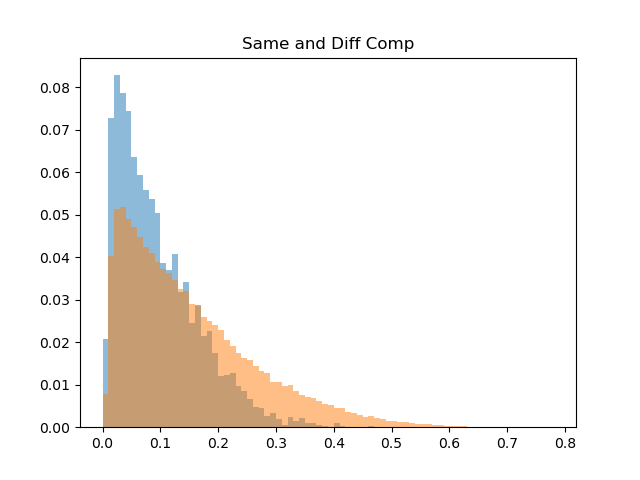

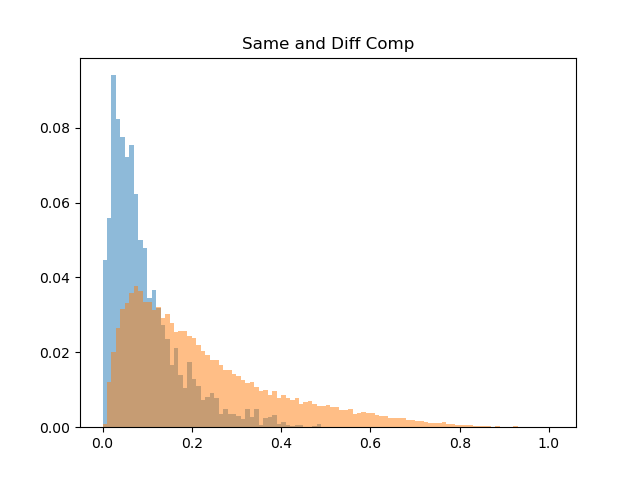

In [33]:
feas_clean_test = extract_node_feature(vers_test,adjs_test)

atkTest = atkM.forward(atkG.forward(nadjs_test,feas_clean_test))

poisonedVersTest = vers_test + translate_by_group(gMats_test,atkTest)

feas_poisoned_test = extract_node_feature(poisonedVersTest,adjs_test)

contraOutPoisonedTest = contraM.forward(contraG.forward(nadjs_test,feas_poisoned_test))

contraOutCleanTest = contraM.forward(contraG.forward(nadjs_test,feas_clean_test))

#display histograms
display_hists(contraOutPoisonedTest, label_mat_test, test_size)
display_hists(contraOutCleanTest, label_mat_test, test_size)

In [34]:
# plt.clf()

torch.Size([1350, 252, 3])


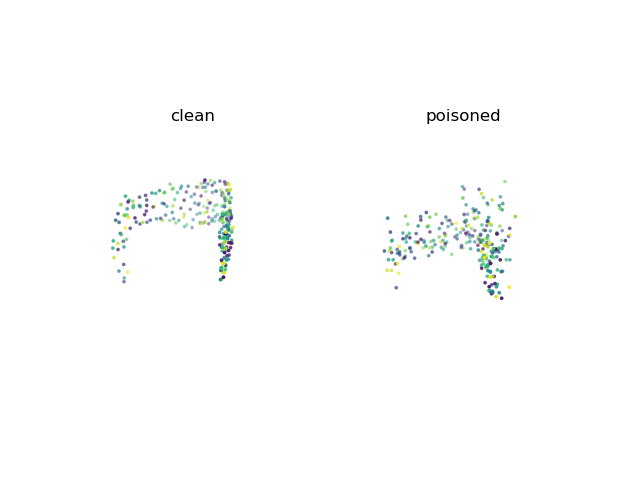

In [35]:
from mpl_toolkits.mplot3d import axes3d


index_in_question = 233

#Plot first clustered mesh
dataPlot = vers[index_in_question]

fig = plt.figure()
ax = fig.add_subplot(121,projection='3d')

ax.scatter(dataPlot[:,0], dataPlot[:,1], dataPlot[:,2], label=gLbls[index_in_question,:], c = gLbls[index_in_question,:], cmap = 'viridis',s = 3)
ax.set_title('clean')

plt.axis('off')

#Plot second clustered point coud
#get poison
atkOut = atkM.forward(atkG.forward(nadjs_train,feas_clean))
poisonedVers = vers_train + translate_by_group(gMats_train,atkOut).detach().numpy()

print(poisonedVers.shape)
#poisioedVers = np.zeros([1350,252,3])
poisonedDataPlot = poisonedVers[index_in_question]

ax = fig.add_subplot(122,projection='3d')

ax.scatter(poisonedDataPlot[:,0], poisonedDataPlot[:,1], poisonedDataPlot[:,2], label=gLbls[index_in_question,:], c = gLbls[index_in_question,:], cmap = 'viridis', s = 3)
ax.set_title('poisoned')

plt.axis('off')

plt.show()

In [36]:
poisonedVers - vers_train

tensor([[[0.1352953315, 0.1342563033, 0.0676251948],
         [0.0344794989, 0.0946581364, 0.1581306458],
         [0.0396301150, 0.0399506688, 0.0373862982],
         ...,
         [0.0337612033, 0.1252720207, 0.0395951569],
         [0.1172747016, 0.1429729313, 0.1351723224],
         [0.0570592284, 0.0719286948, 0.1098847836]],

        [[0.0279082954, 0.0604540706, 0.0438516885],
         [0.1534251124, 0.1399353445, 0.0300431997],
         [0.1583503634, 0.0567576289, 0.0330206901],
         ...,
         [0.0683746338, 0.1599150002, 0.0318082869],
         [0.0362287164, 0.0324389860, 0.0726155341],
         [0.0754408240, 0.0523002930, 0.0376006365]],

        [[0.0347711444, 0.0362161286, 0.1254592538],
         [0.0725107193, 0.0663231090, 0.0446179658],
         [0.1250838637, 0.0544935204, 0.0327014923],
         ...,
         [0.0651857257, 0.0898158476, 0.0714258924],
         [0.0545762181, 0.1017781571, 0.0363344476],
         [0.0336808264, 0.1085308790, 0.0958189815]],

0.9975968
(155, 4)


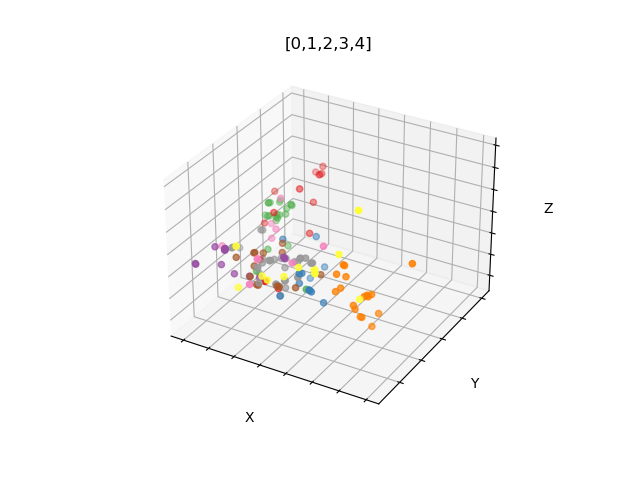

In [39]:
plot_3d_clusters(contraOutCleanTest.detach().numpy(),label_np_test,[i for i in range(10)])

0.99875855
(155, 4)


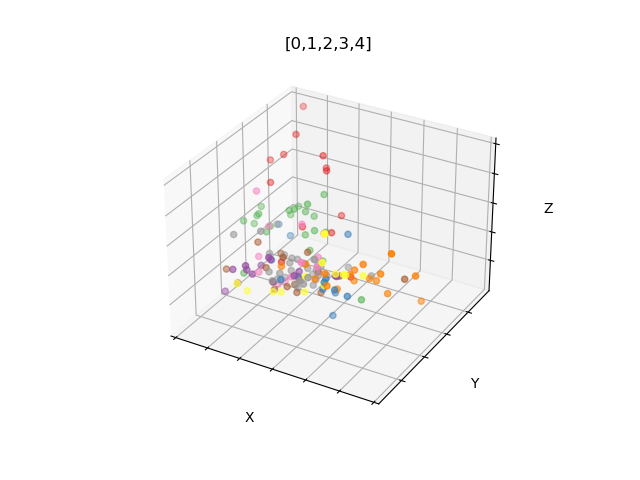

In [40]:
plot_3d_clusters(contraOutPoisonedTest.detach().numpy(),label_np_test,[i for i in range(10)])

In [41]:
saveWeightsDir = 'weights/3-29sdfsfs/'
torch.save(contraG.weights, saveWeightsDir + 'contraGw.pt')
torch.save(contraM.weights, saveWeightsDir + 'contraMw.pt')
torch.save(atkG.weights, saveWeightsDir + 'atkGw.pt') 
torch.save(atkM.weights, saveWeightsDir + 'atkMw.pt')